In [194]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import mean_absolute_error
sns.set_palette("Set2")

In [195]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.dropna(inplace=True)
test.dropna(inplace=True)

In [196]:
train['Cabin'] = train['Cabin'].fillna(method='bfill')
train['Cabin Deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin Num'] = train['Cabin'].apply(lambda x: x.split('/')[1])
train['Cabin Side'] = train['Cabin'].apply(lambda x: x.split('/')[2])
train[["FirstName","LastName"]] = train['Name'].str.split(' ', 1, expand=True)
train['Total Spent'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa']
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0])

test['Cabin'] = test['Cabin'].fillna(method='bfill')
test['Cabin Deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin Num'] = test['Cabin'].apply(lambda x: x.split('/')[1])
test['Cabin Side'] = test['Cabin'].apply(lambda x: x.split('/')[2])
test[["FirstName","LastName"]] = test['Name'].str.split(' ', 1, expand=True)
test['Total Spent'] = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa']
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0])

train.drop('PassengerId', axis =1, inplace = True)
test.drop('PassengerId', axis = 1, inplace = True)

In [197]:
print("Num rows: ", train.shape[0])
print("Num features: ", train.shape[1])

Num rows:  6606
Num features:  20


# Exploratory Data Analysis

<AxesSubplot:xlabel='Cabin Side', ylabel='count'>

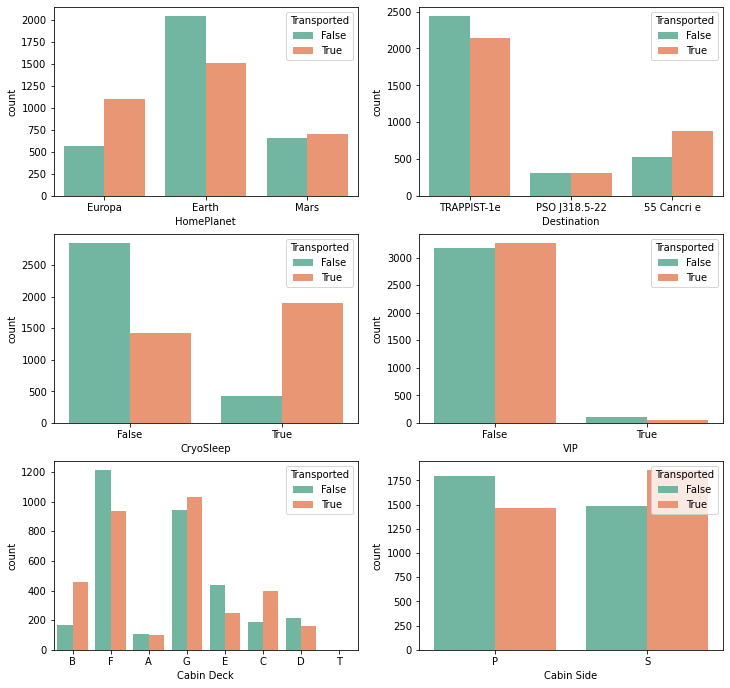

In [199]:
plt.figure(figsize=(12,16))

plt.subplot(4,2,1)
sns.countplot(x="HomePlanet", data=train, hue="Transported")
plt.subplot(4,2,2)
sns.countplot(x="Destination", data=train, hue="Transported")
plt.subplot(4,2,3)
sns.countplot(x="CryoSleep", data=train, hue="Transported")
plt.subplot(4,2,4)
sns.countplot(x="VIP", data=train, hue="Transported")
plt.subplot(4,2,5)
sns.countplot(x="Cabin Deck", data=train, hue="Transported")
plt.subplot(4,2,6)
sns.countplot(x="Cabin Side", data=train, hue="Transported")

<AxesSubplot:xlabel='Age', ylabel='Count'>

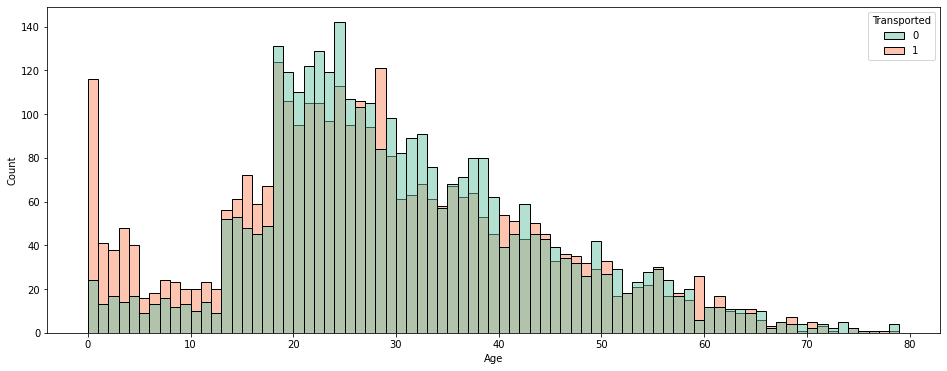

In [192]:
plt.figure(figsize=(16,6))

sns.histplot(data=train, x='Age', hue='Transported', binwidth=1)

## Results of Exploratory Data Analysis
 Passengers between ages 0 to 20 were far more likely to be transported. Cabin Decks A, C and G and Cabin Side S had more transported passengers. Passengers in Cryosleep are far more likely to be transported. Home Planet and Destination do not have a significant influence on transport numbers. VIP status does; there are far less VIPs who were transported than otherwise.

# Feature Selection

In [200]:
# Encoding categorical variables into one-hot vectors and dropping features that will not aid in prediction.
train.drop(['Name', 'FirstName', 'LastName', 'Total Spent'], axis=1)
train_OH_encodings = pd.get_dummies(train[['HomePlanet','Destination','Cabin Deck','Cabin Side']])
test_OH_encodings = pd.get_dummies(test[['HomePlanet','Destination','Cabin Deck','Cabin Side']])

train.drop(['HomePlanet','Destination','Cabin Deck','Cabin Side'], axis = 1, inplace = True)
test.drop(['HomePlanet','Destination','Cabin Deck','Cabin Side'], axis = 1, inplace = True)
train.drop(['Name', 'FirstName', 'LastName', 'Total Spent', 'Cabin'], axis = 1, inplace = True)
test.drop(['Name', 'FirstName', 'LastName', 'Total Spent', 'Cabin'], axis = 1, inplace = True)

train = train.join(train_OH_encodings)
test = test.join(test_OH_encodings)

In [201]:
# Changing booleans into ints
train['CryoSleep'] = train['CryoSleep'].astype(int)
train['VIP'] = train['VIP'].astype(int)
train['Transported'] = train['Transported'].astype(int)
test['CryoSleep'] = test['CryoSleep'].astype(int)
test['VIP'] = test['VIP'].astype(int)

# Models

In [202]:
features = list(train.columns)
features.remove('Transported')
X = train[features]
y = train['Transported']
train_X, val_X, train_y, val_y = train_test_split(X, y)

In [203]:
#Decision Tree

hyperparameters = {
    'max_depth': [2,3,5,10],
    'min_samples_leaf': [5,10],
    "max_leaf_nodes":[None,10,20],
    'splitter': ["best","random"]
}

dt = DecisionTreeClassifier()
dt_clf = GridSearchCV(dt, hyperparameters, cv=10)

dt_model = dt_clf.fit(train_X, train_y)
print('Best max_depth:', dt_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_leaf:', dt_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_leaf_nodes:', dt_model.best_estimator_.get_params()['max_leaf_nodes'])
print('Best splitter:', dt_model.best_estimator_.get_params()['splitter'])
print('')

Best max_depth: 10
Best min_samples_leaf: 5
Best max_leaf_nodes: 20
Best splitter: best



In [165]:
#K-nearest neighbors

hyperparameters = {
    'leaf_size': [1,2,3,4,5],
    'n_neighbors': [1,2,3,4,5],
    "p":[1,2],
}

knn = KNeighborsClassifier()
knn_clf = GridSearchCV(knn, hyperparameters, cv=10)

knn_model = knn_clf.fit(train_X, train_y)
print('Best leaf_size:', knn_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', knn_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', knn_model.best_estimator_.get_params()['n_neighbors'])
# print('MAE: ', mean_absolute_error(knn_model.predict(val_X), val_y))

Best leaf_size: 1
Best p: 1
Best n_neighbors: 5


In [8]:
#SVM

hyperparameters = {
    'C': [0.1], 
    'gamma': [1], 
    'kernel': ['rbf']
}

svr = SVC()
svr_clf = GridSearchCV(svr, hyperparameters, cv=10)

svr_model = svr_clf.fit(train_X, train_y)
print('Best C:', svr_model.best_estimator_.get_params()['C'])
print('Best gamma:', svr_model.best_estimator_.get_params()['gamma'])
print('Best kernel:', svr_model.best_estimator_.get_params()['kernel'])
# print('MAE: ', mean_absolute_error(svr_model.predict(val_X), val_y))

Best C: 0.1
Best gamma: 1
Best kernel: rbf
